In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

import argparse
from copy import deepcopy
import logging
from matplotlib.cm import get_cmap, ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from sklearn.metrics import r2_score
import sys
import torch

sys.path.append('../..')
from data_utils import *

sys.path.append('../../../DeLASE')
from delase import *
from parameter_choosing import *
from performance_metrics import *
from plot import *

# Load Data

In [3]:
chaotic_net_path = "/scratch2/weka/millerlab/eisenaj/DynamicalTrajectories/chaotic_net_data"

W = pd.read_pickle(os.path.join(chaotic_net_path, "W.pkl"))
lyaps = pd.read_pickle(os.path.join(chaotic_net_path, "lyaps_long.pkl"))
full_signals = pd.read_pickle(os.path.join(chaotic_net_path, "chaotic_net_signals_long.pkl"))

In [4]:
N = list(full_signals.values())[0].shape[2]
T = list(full_signals.values())[0].shape[1]
dt = 0.01
tau = 0.1

In [23]:
save_dir = '/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/chaotic_nets_multirun'

In [35]:
# num_runs = 10

# g_vals = list(full_signals.keys())
# W_vals = np.zeros((num_runs, N, N))

# # for g in g_vals:

# t_span = [0, T*dt]
# t_eval = np.arange(t_span[0], t_span[1], dt)

# run_rets = []

# for i in range(num_runs):
#     print("="*40)
#     print(f"RUN {i}")
#     print("="*40)
#     W = np.random.randn(N, N)/np.sqrt(N)
#     W_vals[i] = W
#     signals = {}
#     print("Simulating signals...")
#     for g in tqdm(g_vals):
#         x0 = np.random.randn(N)
#         sol = scipy.integrate.solve_ivp(lambda t, x: rnn(t, x, W=W, tau=tau, g=g), t_span=t_span, t_eval=t_eval, y0=x0)
#         signals[g] = sol.y.T
    
#     print("Signals are simulated!")
    
#     lyaps = {}
#     for key, signal in signals.items():
#         print("-"*20)
#         print(f"g = {key}")
#         print("-"*20)
#         Js = np.zeros((signal.shape[0], N, N))
#         batch_size = 500
#         num_batches = int(np.ceil(signal.shape[0]/batch_size))
#         print("Computing Jacobians..")
#         for batch_num in tqdm(range(num_batches)):
#             start_ind = batch_num*batch_size
#             end_ind = np.min([(batch_num + 1)*batch_size, signal.shape[0]])
#             Js[start_ind:end_ind] = rnn_jacobian(signal[start_ind:end_ind], W, tau, dt, N, use_torch=True, device='cuda').cpu().numpy()
#         print("Computing Lyaps...")
#         lyaps[key] = compute_lyaps(Js, dt, verbose=True)
#     ret = dict(
#         W=W,
#         dt=dt,
#         tau=tau,
#         signals=signals,
#         lyaps=lyaps
#     )
#     pd.to_pickle(ret, os.path.join(save_dir, f"RUN_{i}"))

In [102]:
mp_args = dict(
    # ----------------------
    # MULTIPROCESSING ARGUMENTS
    # ----------------------
    USE_TORCH=False,
    USE_CUDA=False,
    DTYPE='torch.DoubleTensor',
    NUM_WORKERS=3,
#     NUM_WORKERS=4,
    USE_LOGGING=True,
    LOG_DIR="/om2/user/eisenaj/code/shell_scripts/chaotic",
    LOG_NAME='mp_chaotic',
    LOG_LEVEL=logging.DEBUG,
    RESULTS_DIR='/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/chaotic_nets_multirun',
    
    # ==========================
    # CHAOTIC NET ARGUMENTS
    # ==========================
    dt=dt,
    tau=tau,
    N=N,
    T=T,
    batch_size=500,
    num_batches=int(np.ceil(T/batch_size)),
    g_vals=g_vals,
    num_runs=18,
)
data_processing_args_dir = "/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/data_processing_args"
data_processing_path = os.path.join(data_processing_args_dir, "chaotic_multirun_args")
pd.to_pickle(mp_args, data_processing_path)
mp_args = argparse.Namespace(**mp_args)

In [103]:
if not mp_args.USE_CUDA:
    os.system(f"sbatch --gres=gpu:0 --ntasks=1 --cpus-per-task={int(mp_args.NUM_WORKERS) + 2} --mem={int(mp_args.NUM_WORKERS*100) + 10}GB /om2/user/eisenaj/code/shell_scripts/chaotic/mp_chaotic.sh {data_processing_path}")
else:
    os.system(f"sbatch --gres=gpu:{mp_args.NUM_WORKERS} /om2/user/eisenaj/code/shell_scripts/DeLASE/mp_delase.sh {data_processing_path}")

Submitted batch job 30533934


In [104]:
os.system("squeue -u eisenaj")

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          30528510 millerlab cha-jupy  eisenaj  R   14:32:41      1 node031
          30533934    normal mp_chaot  eisenaj  R       0:00      1 node110


0

In [101]:
os.system("scancel 30533918")

0

# Linear Systems

In [3]:
def set_smallest_eigenvalue_real_part(A,lam):

    #lam is the desired maximum eigenvalue
    assert lam < 0, print('Eigenvalue must be negative')

    #get current eigenvalues
    e,v = np.linalg.eig(A)
    largest_eig = np.max(np.real(e))
    I = np.eye(len(e))
  
    #return scaled 
    return A - largest_eig*I + lam*I

def do_one_sde_run(n, lam_awake, lam_anesthesia, awake = 1, random_seed=42):

    np.random.seed(random_seed)

    A = np.random.normal(0,1/np.sqrt(n),(n,n))

    if awake == 1:
        #pick the stability parameter
        lam = lam_awake

        # Define the Weiner process    
        dW = np.sqrt(dt) * np.random.randn(N,n)

        #define systems matrix
        A_awake = set_smallest_eigenvalue_real_part(A,lam)

    else:

        lam = lam_anesthesia

        dW = np.sqrt(dt) * np.random.randn(N,n)

        A_anesthesia = set_smallest_eigenvalue_real_part(A,lam)


    # Define the function f(x)
    def f(x,lam):
        if awake == 1:
            return A_awake @ x
        else:
            return A_anesthesia @ x


    # Define the function g(x)
    def g(x):
        return 1

    # Initialize the x array
    x = np.zeros((N,n))
    x[0] = np.zeros(n)

    # Simulate the stochastic differential equation
    for i in range(1, N):
        x[i] = x[i-1] + f(x[i-1],lam) * dt + g(x[i-1]) * dW[i]

    return x

In [4]:
use_torch=True
device = 'cuda'

In [5]:
NUM_RUNS = 20
save_dir = '/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/linear_noise_multirun'

In [6]:
# Define the parameters
# N = int(1e5)
N = 20000
n = 100
T = 40.0
dt = T / N
x0 = 0.0

lams = [-1, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1]

parameter_grid = ParameterGrid(
    window_vals=np.array([10000]),
    matrix_size_vals=np.array([10, 20, 50, 100, 200, 300, 500, 750, 1000]),
    r_vals=np.array([3, 5, 10, 25, 50, 75, 100, 125, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 900, 1000])
)


prediction_time = 5000
transient = 2000

for i in range(NUM_RUNS):
    if not os.path.exists(os.path.join(save_dir, f"RUN_{i}")):
        print("="*40)
        print(f"RUN {i}")
        print("="*40)

        print("Simulating...")
        trajs = {}
        for lam in lams:
            x_1 = do_one_sde_run(n, lam_awake = lam, lam_anesthesia = 0, awake = 1, random_seed=42 + i)
            trajs[lam] = x_1
        #         plt.plot(np.linspace(0, T, N), x_1[:,0], label = f'$\lambda_1(A) = {lam}$')
        #     plt.legend()
        #     plt.show()
        num_samples = 10
        indices = np.random.choice(np.arange(n), num_samples, replace=False)
        for key in trajs.keys():
            trajs[key] = trajs[key][:, indices]
        print("Simulated!")

        signals = trajs

        mean_stab_curve = True
        true_vals = lams
        keys = np.array(lams)
        key_inds = np.arange(len(lams))

        print("Computing DeLASE...")
        results = []
        iterator = tqdm(total=len(parameter_grid.window_vals)*len(parameter_grid.matrix_size_vals)*len(parameter_grid.r_vals))
        for window in parameter_grid.window_vals:
            for matrix_size in parameter_grid.matrix_size_vals:
                delases = {}
                exp_variances = {}
        #         train_signals = []
                test_signals = {}
                for key, signal in signals.items():
                    train_signal = signal[transient:transient + window]
                    test_signal = signal[transient + window:transient + window + prediction_time]
                    delase = DeLASE(train_signal, matrix_size=matrix_size, dt=dt, use_torch=use_torch, device=device, dtype='torch.DoubleTensor')
                    delase.to('cpu')
                    if use_torch:
                        exp_variances[key] = delase.cumulative_explained_variance.cpu().double()
                    else:
                        exp_variances[key] = delase.cumulative_explained_variance
                    delases[key] = delase
        #             train_signals.append(train_signal)
                    test_signals[key] = test_signal
                for r in parameter_grid.r_vals:
                    if r <= np.min([delase.n*delase.p for delase in delases.values()]):
                        stab_curves = {}
                        AICs = {}
                        for key, delase in delases.items():
                            delase.to('cuda')
                            delase.compute_havok_dmd(r=r)
                            delase.get_stability(max_freq=500, max_unstable_freq=125)

                            AICs[key] = compute_AIC(delase, test_signals[key])
                            if use_torch:
                                stab_curves[key] = delase.stability_params.cpu()
                            else:
                                stab_curves[key] = delase.stability_params

                        if use_torch:
                            exp_variances = np.array([delase.cumulative_explained_variance[r-1].cpu().numpy() for delase in delases.values()])
                        else:
                            exp_variances = np.array([delase.cumulative_explained_variance[r-1] for delase in delases.values()])

                        results.append(dict(
                            window=window,
                            matrix_size=matrix_size,
                            r=r,
                            exp_variances=exp_variances,
                            AICs=AICs,
                            stab_curves=stab_curves,
                        ))

                    iterator.update()
        iterator.close()

        results = pd.DataFrame(results)
        results_dict = {}
        for key in lams:
            ret_temp = results.copy()
            ret_temp = ret_temp.drop('AICs', axis=1)
            ret_temp = ret_temp.drop('stab_curves', axis=1)
            ret_temp = ret_temp.drop('exp_variances', axis=1)
            ret_temp['AIC'] = results.AICs.apply(lambda x: x[key])
            ret_temp['stab_curves'] = results.stab_curves.apply(lambda x: x[key])
            ret_temp = ret_temp.set_index((['window', 'matrix_size', 'r']))
            results_dict[key] = ret_temp


        pd.to_pickle(results_dict, os.path.join(save_dir, f"RUN_{i}"))

RUN 2
Simulating...
Simulated!
Computing DeLASE...


  0%|          | 0/216 [00:00<?, ?it/s]

RUN 3
Simulating...
Simulated!
Computing DeLASE...


  0%|          | 0/216 [00:00<?, ?it/s]

RUN 4
Simulating...
Simulated!
Computing DeLASE...


  0%|          | 0/216 [00:00<?, ?it/s]

RUN 5
Simulating...
Simulated!
Computing DeLASE...


  0%|          | 0/216 [00:00<?, ?it/s]

RUN 6
Simulating...
Simulated!
Computing DeLASE...


  0%|          | 0/216 [00:00<?, ?it/s]

RUN 7
Simulating...
Simulated!
Computing DeLASE...


  0%|          | 0/216 [00:00<?, ?it/s]

RUN 8
Simulating...
Simulated!
Computing DeLASE...


  0%|          | 0/216 [00:00<?, ?it/s]

RUN 9
Simulating...
Simulated!
Computing DeLASE...


  0%|          | 0/216 [00:00<?, ?it/s]

RUN 10
Simulating...
Simulated!
Computing DeLASE...


  0%|          | 0/216 [00:00<?, ?it/s]

RUN 11
Simulating...
Simulated!
Computing DeLASE...


  0%|          | 0/216 [00:00<?, ?it/s]

RUN 12
Simulating...
Simulated!
Computing DeLASE...


  0%|          | 0/216 [00:00<?, ?it/s]

RUN 13
Simulating...
Simulated!
Computing DeLASE...


  0%|          | 0/216 [00:00<?, ?it/s]

RUN 14
Simulating...
Simulated!
Computing DeLASE...


  0%|          | 0/216 [00:00<?, ?it/s]

RUN 15
Simulating...
Simulated!
Computing DeLASE...


  0%|          | 0/216 [00:00<?, ?it/s]

RUN 16
Simulating...
Simulated!
Computing DeLASE...


  0%|          | 0/216 [00:00<?, ?it/s]

RUN 17
Simulating...
Simulated!
Computing DeLASE...


  0%|          | 0/216 [00:00<?, ?it/s]

RUN 18
Simulating...
Simulated!
Computing DeLASE...


  0%|          | 0/216 [00:00<?, ?it/s]

RUN 19
Simulating...
Simulated!
Computing DeLASE...


  0%|          | 0/216 [00:00<?, ?it/s]

# Load Linear Systems Data

In [3]:
save_dir = '/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/linear_noise_multirun'

In [8]:
lams = [-1, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1]

In [5]:
rets = []
for f in tqdm(os.listdir(save_dir)):
    rets.append(pd.read_pickle(os.path.join(save_dir, f)))

  0%|          | 0/20 [00:00<?, ?it/s]

In [42]:
ret_means = np.zeros(len(lams))
ret_mean_counts = np.zeros(len(lams))
for ret in tqdm(rets):
    window, matrix_size, r, all_results = combine_grid_results(ret)
    
    for i, key in enumerate(lams):
        stab_curve = ret[key].loc[(window, matrix_size, r)].stab_curves
        
        ret_means[i] += stab_curve[:int(top_percent*len(stab_curve))].sum()
        ret_mean_counts[i] += int(top_percent*len(stab_curve))
        
ret_means = ret_means/ret_mean_counts

  0%|          | 0/20 [00:00<?, ?it/s]

In [43]:
ret_means_se = np.zeros(len(lams))
ret_mean_se_counts = np.zeros(len(lams))
for ret in tqdm(rets):
    window, matrix_size, r, all_results = combine_grid_results(ret)
    
    for i, key in enumerate(lams):
        stab_curve = ret[key].loc[(window, matrix_size, r)].stab_curves
        
        ret_means_se[i] += ((stab_curve[:int(top_percent*len(stab_curve))] - ret_means[i])**2).sum()
        ret_mean_se_counts[i] += int(top_percent*len(stab_curve))
ret_means_se = np.sqrt(ret_means_se/ret_mean_se_counts)/np.sqrt(ret_mean_se_counts)

  0%|          | 0/20 [00:00<?, ?it/s]

In [54]:
lams

[-1, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1]

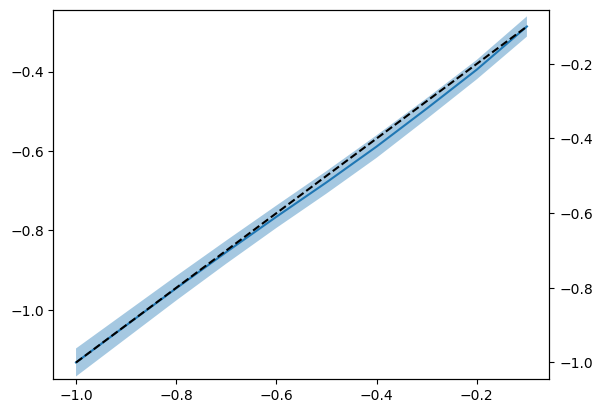

In [73]:
plt.plot(lams, ret_means)
ax = plt.gca()
ax2 = ax.twinx()
ax2.plot(lams, lams, linestyle='--', c='k')
ylim = ax.get_ylim()
ax.fill_between(lams, ret_means - ret_means_se, ret_means + ret_means_se, alpha=0.4)
ax.set_ylim(ylim)
plt.show()

In [60]:
scipy.stats.pearsonr(lams, ret_means)

(0.9996836769223176, 4.378614439172579e-14)

tensor([-1.1268, -1.4280])

In [11]:
top_percent = 0.1

In [6]:
rets[0]

{-1:                                   AIC  \
 window matrix_size r                    
 10000  10          3    -7.869681e+04   
                    5    -9.081149e+04   
                    10   -3.102073e+05   
        20          3    -7.864290e+04   
                    5    -9.071531e+04   
 ...                               ...   
        1000        700   6.813581e+05   
                    750   8.260484e+05   
                    800   9.808481e+05   
                    900   1.320633e+06   
                    1000  1.700897e+06   
 
                                                                stab_curves  
 window matrix_size r                                                        
 10000  10          3     [tensor(-0.8227), tensor(-1.1843), tensor(-1.1...  
                    5     [tensor(-0.9174), tensor(-1.3682), tensor(-1.4...  
                    10    [tensor(-1.1268), tensor(-1.4280), tensor(-1.6...  
        20          3     [tensor(-0.3338), tensor(-0.3338

### Analysis

In [157]:
window, matrix_size, r, all_results = combine_grid_results(results_dict)

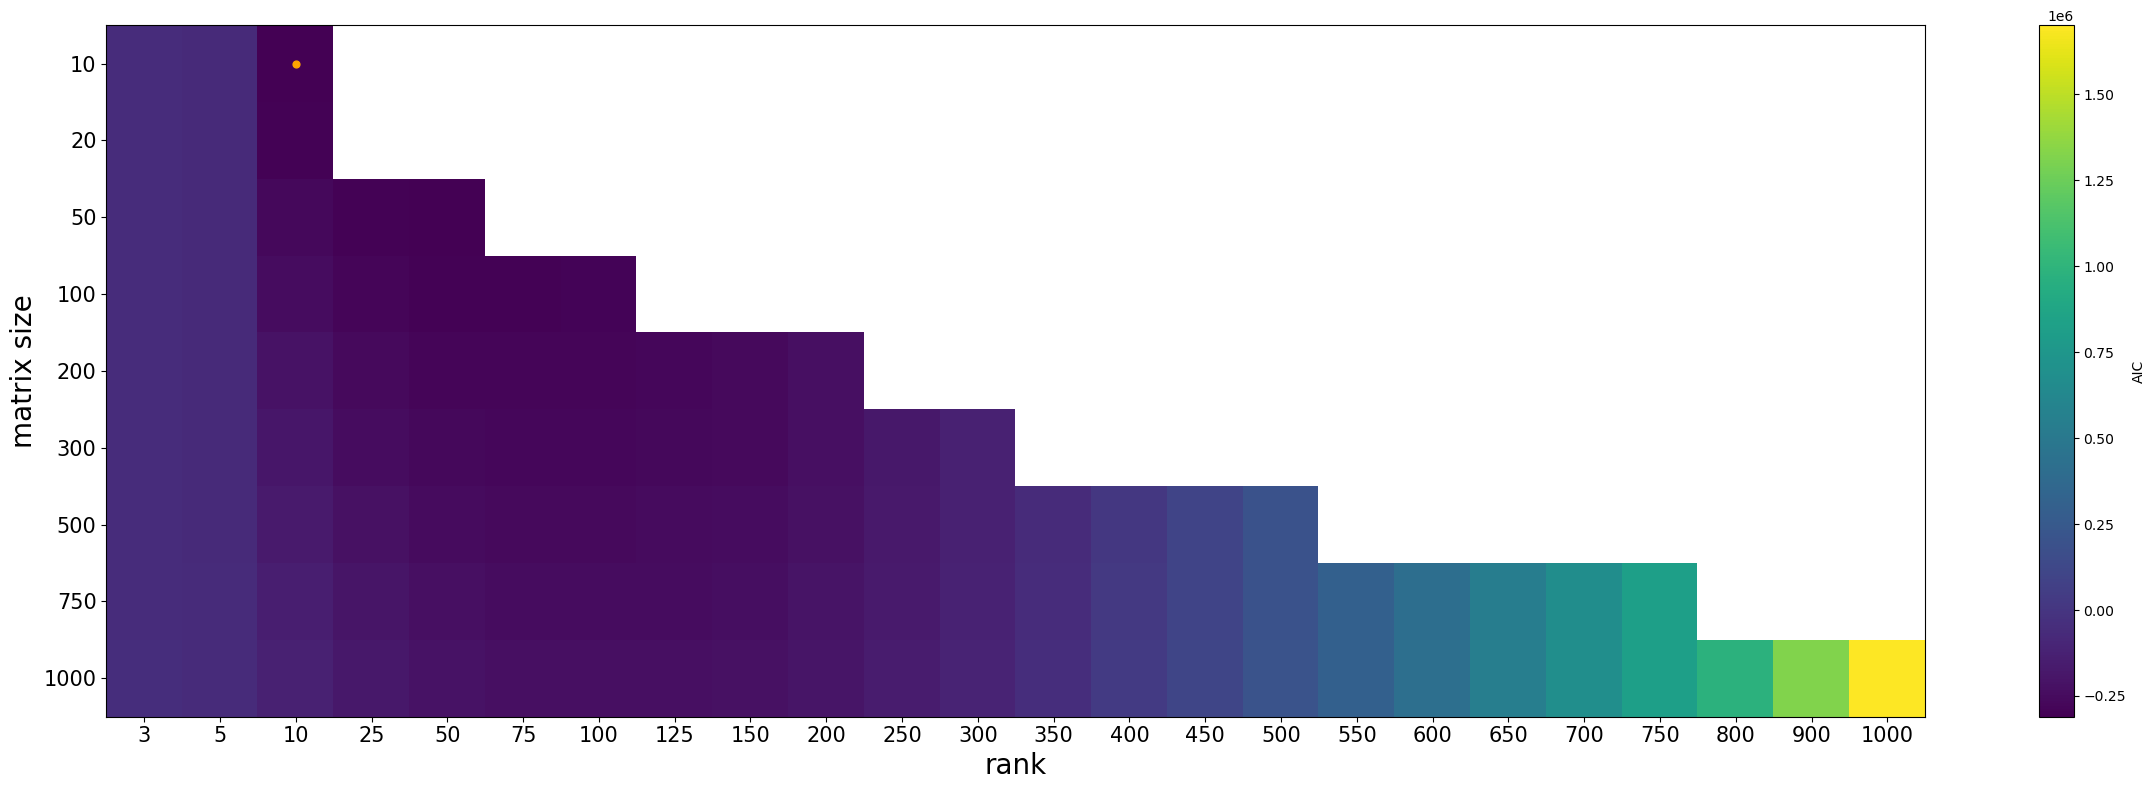

In [169]:
plot_AIC(results_dict)

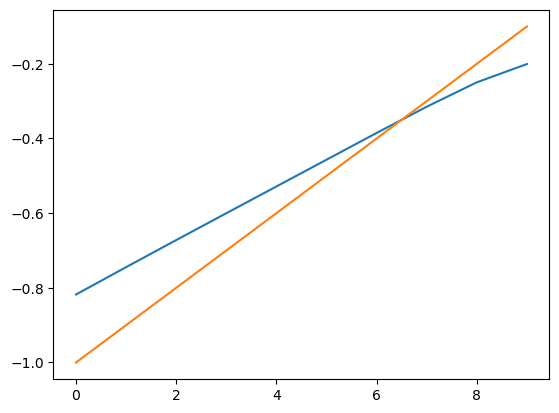

In [172]:
plt.plot([results_dict[key].loc[(window, matrix_size, r)].stab_curves[:2].mean() for key in lams])
plt.plot(lams)

In [ ]:
plt.plot()